In [2]:
import numba
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit
import scipy

In [3]:
T=1
R=0.001
D = 10*R


steps = 10000
nsteps = 10000
#initial positions 


epsilons = np.linspace(0.01,0.5,50)*D


In [4]:
def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))




In [5]:
@njit
def getDistanceMatrix(A):
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return distances

In [6]:
@njit
def tile(x):
    tiled = np.zeros((5,5,3))
    for i in range(5):
        tiled[i,:,:] = x
        
    return tiled


In [7]:
@njit
def tile2(x):
    tiled = np.zeros((5,5,3,3))
    for i in range(3):
        for j in range(3):
            tiled[:,:,i,j] = x
        
    return tiled

In [8]:
@njit
def getO(d):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((5,5,3,3))

    for i in range(5):
        for j in range(5):
            I5_5_3_3[i,j,:,:] = np.eye(3)


    c1 = d.reshape(5,5,3,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)

    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)

    for i in range(5):  #for i=j
        O[i,i,:,:] = np.eye(3)
    return O

In [9]:
@njit
def getA(d):
    k2_3 = np.dot(d[1,0],d[1,0])*np.dot(d[2,0],d[2,0])/np.dot(d[1,0],d[2,0])
    k2_4 = np.dot(d[1,0],d[1,0])*np.dot(d[3,0],d[3,0])/np.dot(d[1,0],d[3,0])
    k2_5 = np.dot(d[1,0],d[1,0])*np.dot(d[4,0],d[4,0])/np.dot(d[1,0],d[4,0])
    k3_4 = np.dot(d[2,0],d[2,0])*np.dot(d[3,0],d[3,0])/np.dot(d[2,0],d[3,0])
    k3_5 = np.dot(d[2,0],d[2,0])*np.dot(d[4,0],d[4,0])/np.dot(d[2,0],d[4,0])

    p2_3 = np.dot(d[2,0],d[2,0])*d[0,1] - k2_3*d[0,2] 
    p2_4 = np.dot(d[3,0],d[3,0])*d[0,1] - k2_4*d[0,3] 
    p2_5 = np.dot(d[4,0],d[4,0])*d[0,1] - k2_5*d[0,4] 
    p3_4 = np.dot(d[3,0],d[3,0])*d[0,2] - k3_4*d[0,3] 
    p3_5 = np.dot(d[4,0],d[4,0])*d[0,2] - k3_5*d[0,4] 


    q2_3 = np.dot(d[1,0],d[1,0])*d[0,2] - k2_3*d[0,1] 
    q2_4 = np.dot(d[1,0],d[1,0])*d[0,3] - k2_4*d[0,1] 
    q2_5 = np.dot(d[1,0],d[1,0])*d[0,4] - k2_5*d[0,1] 
    q3_4 = np.dot(d[2,0],d[2,0])*d[0,3] - k3_4*d[0,2] 
    q3_5 = np.dot(d[2,0],d[2,0])*d[0,4] - k3_5*d[0,2] 


    # 
    # 
    A1_3 = np.array([
    
    [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,     0, 0, 0,                    1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,     0, 0, 0,                    0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,     0, 0, 0,                    0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
        
    A4_15 = np.array([
    
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0,      0, d[0,1,2], -d[0,1,1], 0, d[0,2,2], -d[0,2,1], 0, d[0,3,2], -d[0,3,1], 0, d[0,4,2], -d[0,4,1]],   
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0,     -d[0,1,2], 0, d[0,1,0], -d[0,2,2], 0, d[0,2,0], -d[0,3,2], 0, d[0,3,0], -d[0,4,2], 0, d[0,4,0]],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0,     d[0,1,1], -d[0,1,0], 0, d[0,2,1], -d[0,2,0], 0, d[0,3,1], -d[0,3,0], 0, d[0,4,1], -d[0,4,0], 0],

    [d[1,0,0], d[1,0,1], d[1,0,2], -d[1,0,0], -d[1,0,1], -d[1,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0,     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[2,0,0], d[2,0,1], d[2,0,2], 0, 0, 0, -d[2,0,0], -d[2,0,1], -d[2,0,2], 0, 0, 0, 0, 0, 0,     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   
    [d[3,0,0], d[3,0,1], d[3,0,2], 0, 0, 0, 0, 0, 0, -d[3,0,0], -d[3,0,1], -d[3,0,2], 0, 0, 0,     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[4,0,0], d[4,0,1], d[4,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, -d[4,0,0], -d[4,0,1], -d[4,0,2],     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    
    [-p2_3[0] -q2_3[0], -p2_3[1] -q2_3[1], -p2_3[2] -q2_3[2],                p2_3[0], p2_3[1], p2_3[2], q2_3[0], q2_3[1], q2_3[2], 0, 0, 0, 0, 0, 0,       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #2_3,
    [-p2_4[0] -q2_4[0], -p2_4[1] -q2_4[1], -p2_4[2] -q2_4[2],                p2_4[0], p2_4[1], p2_4[2], 0, 0, 0, q2_4[0], q2_4[1], q2_4[2], 0, 0, 0,       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  #2_4,
    [-p2_5[0] -q2_5[0], -p2_5[1] -q2_5[1], -p2_5[2] -q2_5[2],                p2_5[0], p2_5[1], p2_5[2], 0, 0, 0, 0, 0, 0, q2_5[0], q2_5[1], q2_5[2],       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #2_5
    [-p3_4[0] -q3_4[0], -p3_4[1] -q3_4[1], -p3_4[2] -q3_4[2],                0, 0, 0, p3_4[0], p3_4[1], p3_4[2], q3_4[0], q3_4[1], q3_4[2], 0, 0, 0,       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  #3_4
    [-p3_5[0] -q3_5[0], -p3_5[1] -q3_5[1], -p3_5[2] -q3_5[2],                0, 0, 0, p3_5[0], p3_5[1], p3_5[2], 0, 0, 0, q3_5[0], q3_5[1], q3_5[2],       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #3_5
    
    ])

    

    O = getO(d)
    newO = np.zeros((15,15))
    for i in range(5):
        for j in range(5):
            newO[3*i:3*i+3,3*j:3*j+3] = O[i,j]
            
    A16_30  = np.concatenate((-np.eye(15),newO),axis=1)
    
# 
# # A16 = [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,     O1_1[1_1], O1_1[1_2], O1_1[1_3], O1_2, O1_3, O1_4, O1_5]
# # A17 = [0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      O1_1[2_1], O1_1[2_2], O1_1[2_3], O1_2, O1_3, O1_4, O1_5]
# # A18 = [0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,    O1_1[3_1], O1_1[3_2], O1_1[3_3], O1_2, O1_3, O1_4, O1_5]
# 
    A = np.concatenate((A1_3,A4_15,A16_30),axis=0)
    # print(np.linalg.det(A))
    return A

In [10]:
@njit
def getC(l,u):
    lu = np.zeros(4)
    for i in range(4):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([0,0,0, 0,0,0, *list(lu), 0,0,0,0,0,        0,0,0, 0,0,0, 0,0,0, 0,0,0, 0,0,0])  #not 1

In [11]:
@njit
def getV(r,l,u):
    d = getDistanceMatrix(r)
    
    A = getA(d)
    C = getC(l,u)
    
    return np.linalg.solve(A,C)[:15]


In [12]:
@njit
def step(r,L,U):
    #zs = []
    for t in range(nsteps):
        v = getV(r,L[:,t],U).reshape((5,3))
        
        r += v
     #   zs.append(r[0,0])
        
        
    return r
        

In [13]:
def visualize(r,angles=(0,0)):
    ax = plt.figure().add_subplot(projection='3d')
    colors = ('r', 'g', 'b', 'k','y')
    ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)
    
    for j in range(0,5):
        ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
    
    ax.view_init(angles[0],angles[1])
    plt.show()
    

In [14]:
@njit
def act(r,L,U):
    r_final = step(r.copy(),L,U)
    delta = list(r_final - r)[0]
    
    
    c = r_final[1]-r_final[0] - (r[1] - r[0])

    dTheta = getTheta(r_final) - getTheta(r)
    dPhi = getPhi(r_final) - getPhi(r)
    
    return r_final,np.array([*delta,dTheta,dPhi])

In [15]:
@njit
def getTheta(r):
    return (180/np.pi)*np.arctan(np.sqrt((r[1,0]-r[0,0])**2 + (r[1,1]-r[0,1])**2)/(r[1,2]-r[0,2]))
    
@njit
def getPhi(r):
    d2 = r[1] - r[0]
    d3 = r[2] - r[0]
    
    c = d3 - d2*np.dot(d3,d2)/np.dot(d2,d2)
    return (180/np.pi)*np.arctan(c[1]/c[0])

0.0001


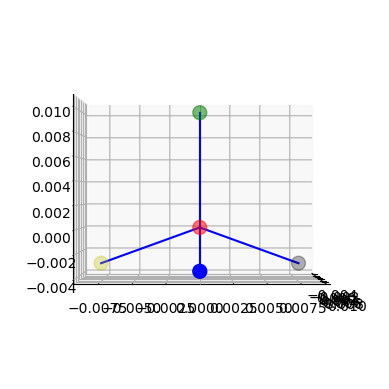

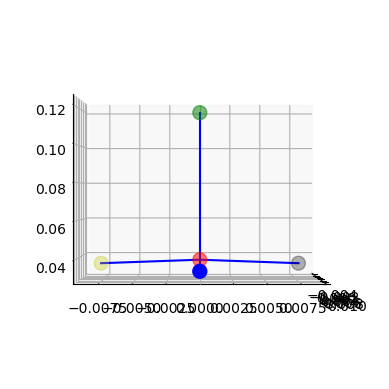

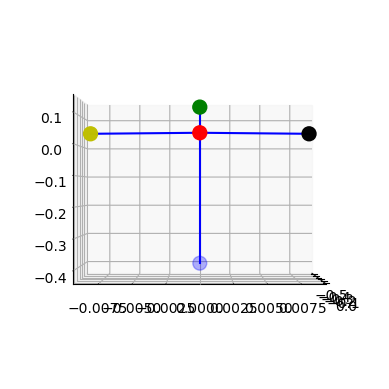

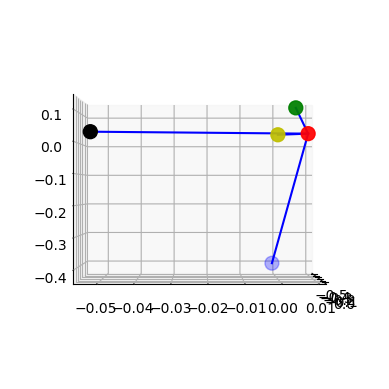

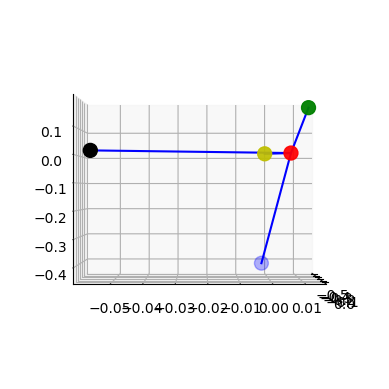

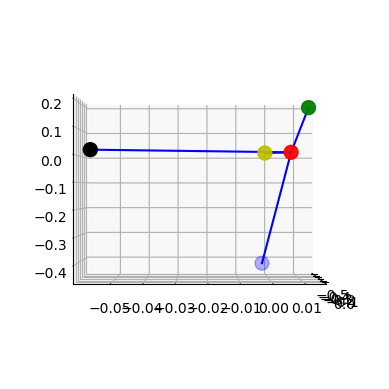

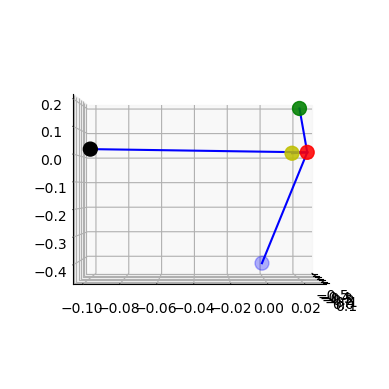

In [16]:


epsilon = epsilons[0]
a = D


r0 = np.array([[0, 0, 0],
[0, 0, a],
[a*np.sqrt(8)/3, 0 , -a/3],
[-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
[-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])

w = epsilon/T

print(epsilon)

closing  = D - np.arange(steps)*epsilon/steps
opening = D - epsilon + np.arange(steps)*epsilon/steps
opened = D *np.ones(steps)
closed = (D-epsilon)*np.ones(steps)
    
    
visualize(r0)   
rf1,_ =  act(r0,np.array([closing,opened,opened,opened]),np.array([-w,0,0,0]))
visualize(rf1)   
rf2,_ =  act(rf1,np.array([closed,closing,opened,opened]),np.array([0,-w,0,0]))
visualize(rf2)
rf3,_ =  act(rf2,np.array([closed,closed,closing,opened]),np.array([0,0,-w,0]))
visualize(rf3)
rf4,_ =  act(rf3,np.array([opening,closed,closed,opened]),np.array([w,0,0,0]))
visualize(rf4)
rf5,_ =  act(rf4,np.array([opened,opening,closed,opened]),np.array([0,w,0,0]))
visualize(rf5)
rf6,change =  act(rf5,np.array([opened,opened,opening,opened]),np.array([0,0,w,0]))
visualize(rf6)
    
    
    
    
 


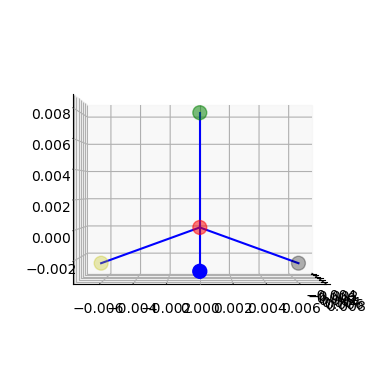

In [49]:
visualize(r0)

In [39]:
def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))


getAngle(rf2[1]-rf2[0],rf2[4]-rf2[0])

70.45015809001808

In [238]:
data = np.zeros((8,5,50))
for i in range(50):
    
    epsilon = epsilons[i]



    w = epsilon/T


    print(epsilon)




    closing  = a - np.arange(steps)*epsilon/steps
    opening = a - epsilon + np.arange(steps)*epsilon/steps
    opened = a *np.ones(steps)
    closed = (a-epsilon)*np.ones(steps)
    
    
    a2 = a -epsilon
    
    
  
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    

    _,data[0,:,i] = act(r0,np.array([opening,closed,closed,closed]),np.array([w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    _,data[1,:,i] = act(r0,np.array([closing,closed,closed,closed]),np.array([-w,0,0,0]))
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    
    _,data[2,:,i] = act(r0,np.array([opening,opened,closed,closed]),np.array([w,0,0,0]))
    
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    _,data[3,:,i] = act(r0,np.array([closing,opened,closed,closed]),np.array([-w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    _,data[4,:,i] = act(r0,np.array([opening,opened,opened,closed]),np.array([w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    _,data[5,:,i] = act(r0,np.array([closing,opened,opened,closed]),np.array([w,0,0,0]))

    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])
    
    _,data[6,:,i] = act(r0,np.array([opening,opened,opened,opened]),np.array([-w,0,0,0]))
    
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])
    
    _,data[7,:,i] = act(r0,np.array([closing,opened,opened,opened]),np.array([w,0,0,0]))
    
    # rf,_ =  act(r0,np.array([closing,opened,opened,opened]),np.array([-w,0,0,0]))
    # 
    # rf,_ =  act(rf,np.array([closed,closing,opened,opened]),np.array([0,-w,0,0]))
    # 
    # rf,_ =  act(rf,np.array([closed,closed,closing,opened]),np.array([0,0,-w,0]))
    # 
    # rf,_ =  act(rf,np.array([opening,closed,closed,opened]),np.array([w,0,0,0]))
    # 
    # rf,_ =  act(rf,np.array([opened,opening,closed,opened]),np.array([0,w,0,0]))
    # 
    # rf,change =  act(rf,np.array([opened,opened,opening,opened]),np.array([0,0,w,0]))
    # visualize(rf)
    # 
    # data[i,:] = change
    
    
    
 


    


#save data

0.1
0.1489795918367347
0.19795918367346937
0.24693877551020407
0.29591836734693877
0.3448979591836735
0.3938775510204081
0.44285714285714284
0.49183673469387756
0.5408163265306122
0.5897959183673469
0.6387755102040816
0.6877551020408162
0.736734693877551
0.7857142857142857
0.8346938775510203
0.883673469387755
0.9326530612244898
0.9816326530612244
1.030612244897959
1.079591836734694
1.1285714285714286
1.1775510204081634
1.226530612244898
1.2755102040816326
1.3244897959183675
1.373469387755102
1.4224489795918367
1.4714285714285715
1.5204081632653061
1.5693877551020408
1.6183673469387756
1.6673469387755102
1.7163265306122448
1.7653061224489797
1.8142857142857143
1.863265306122449
1.9122448979591837
1.9612244897959183
2.010204081632653
2.059183673469388
2.1081632653061226
2.157142857142857
2.206122448979592
2.2551020408163267
2.304081632653061
2.353061224489796
2.4020408163265308
2.451020408163265
2.5


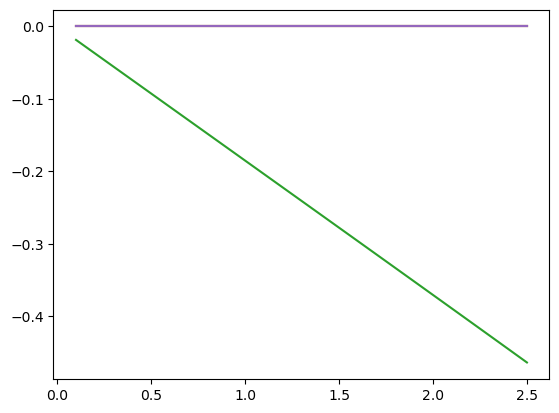

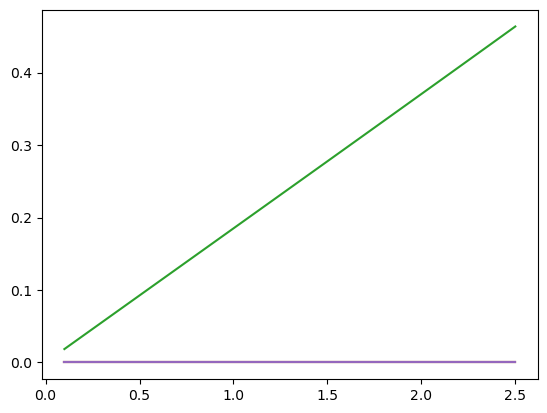

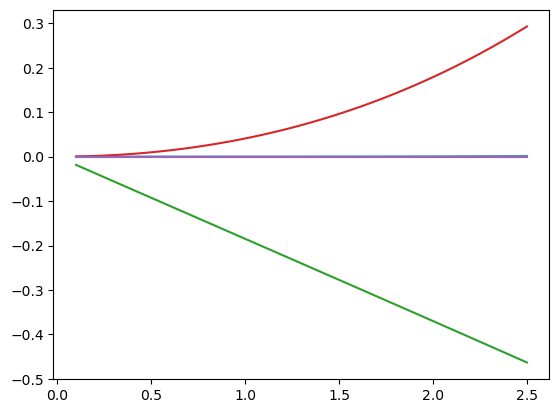

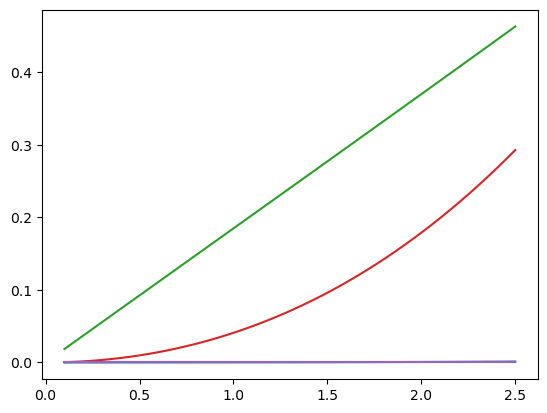

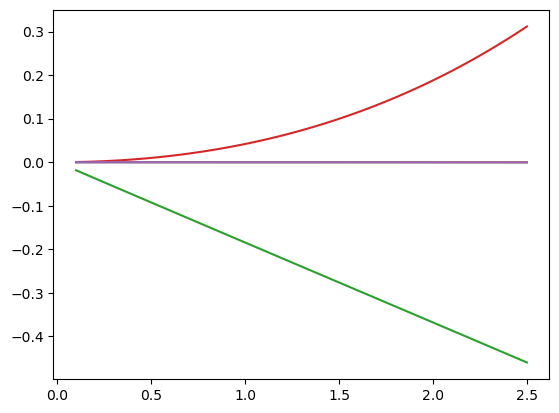

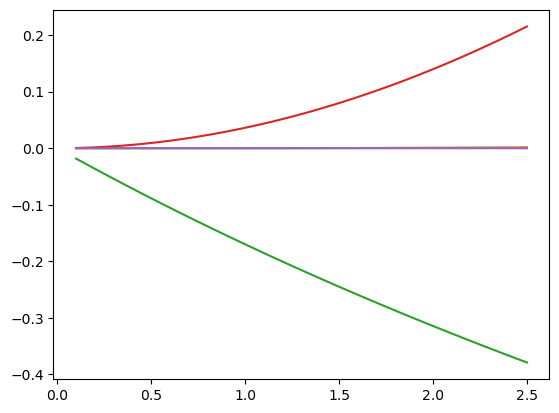

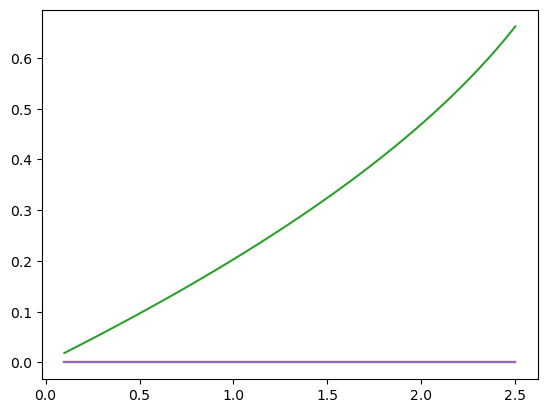

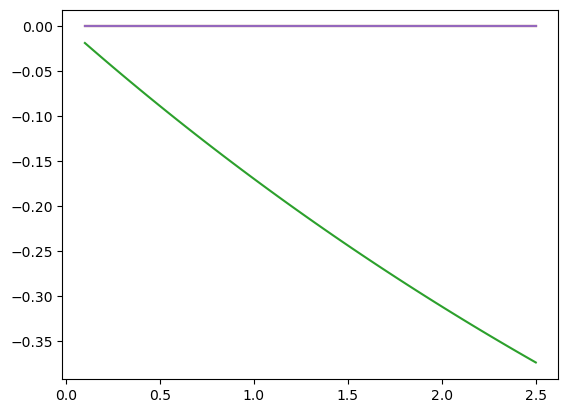

In [239]:
for i in range(8):
    for j in range(5):
        plt.plot(epsilons,data[i,j,:])
    plt.show()

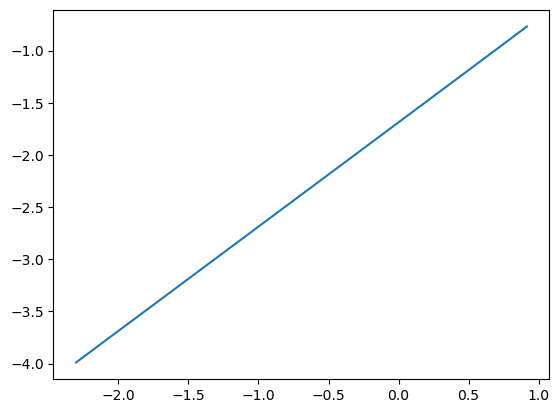

1.0004317841418426


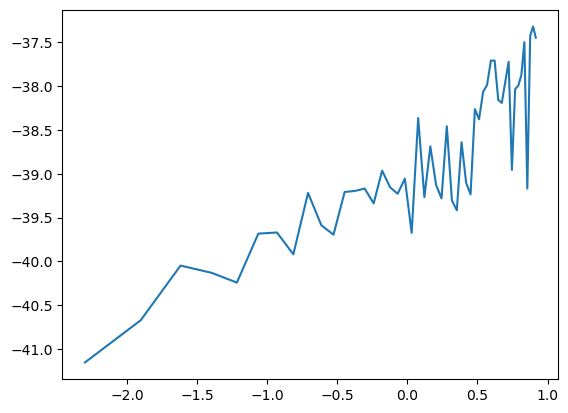

0.9864845838550458


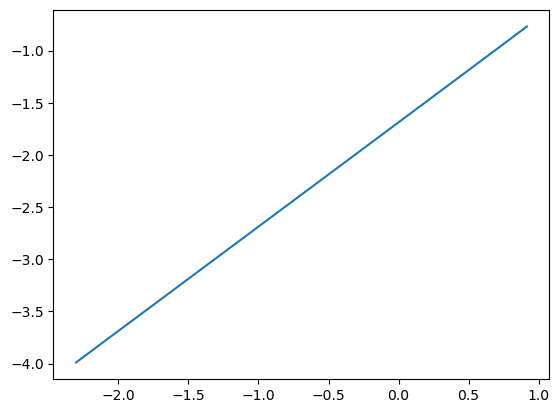

1.0004319635217922


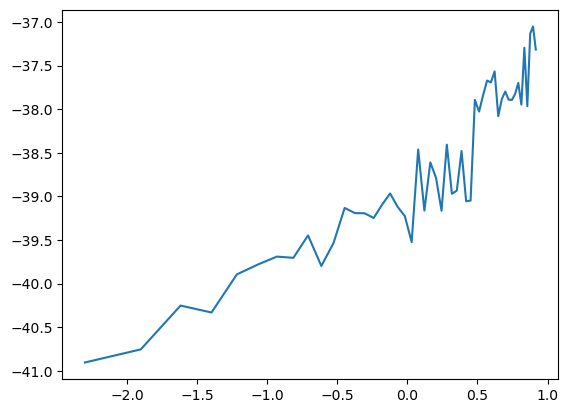

1.1218663668741853


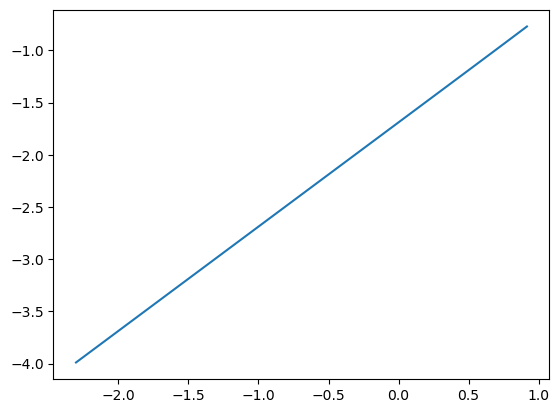

0.9998026229942921


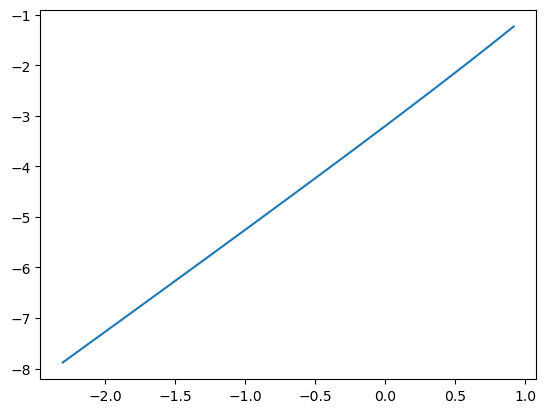

2.075321933899558


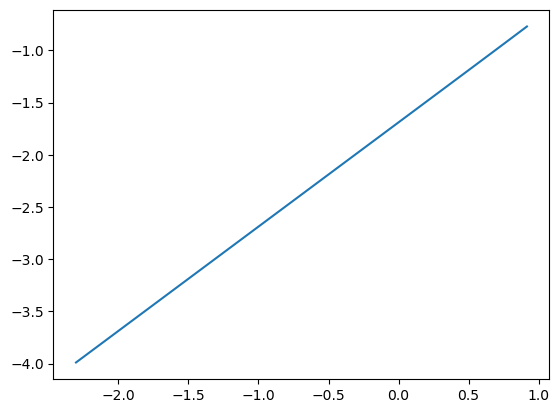

0.999802239159984


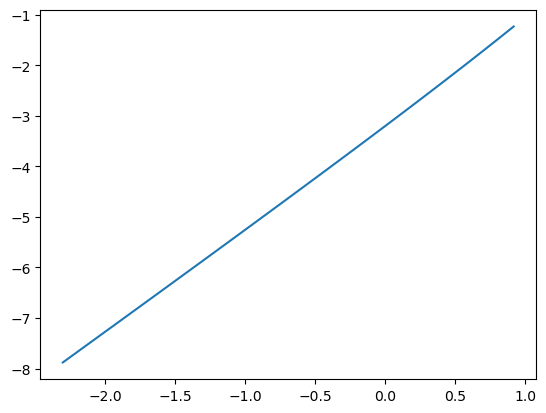

2.0753234535698932


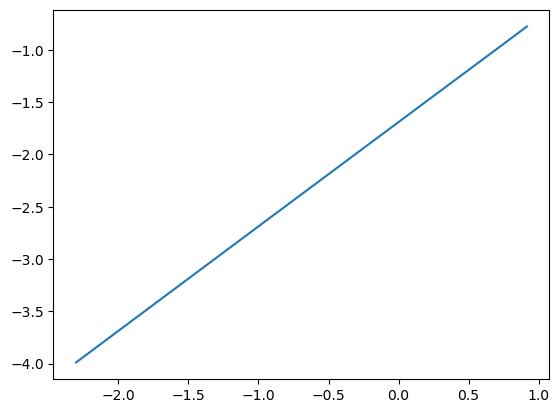

0.997452130325103


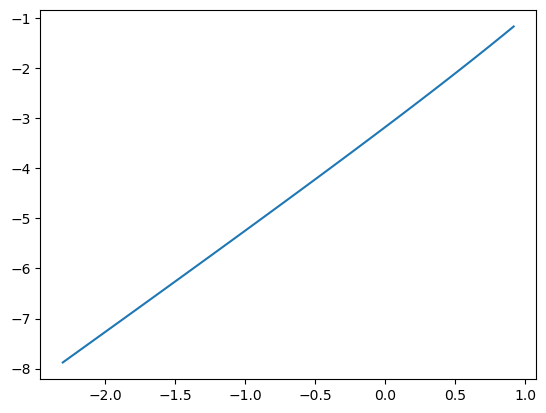

2.096252608010849


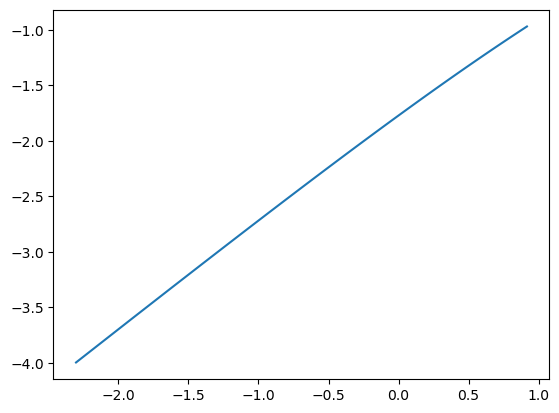

0.932040042865642


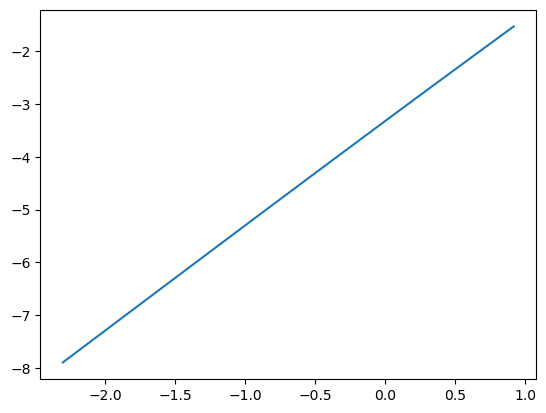

1.971222392086489


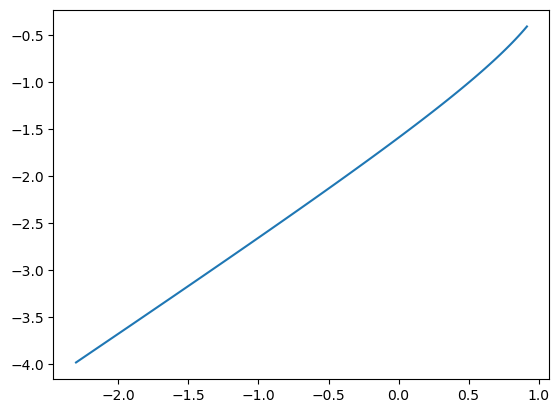

1.1107124011479481


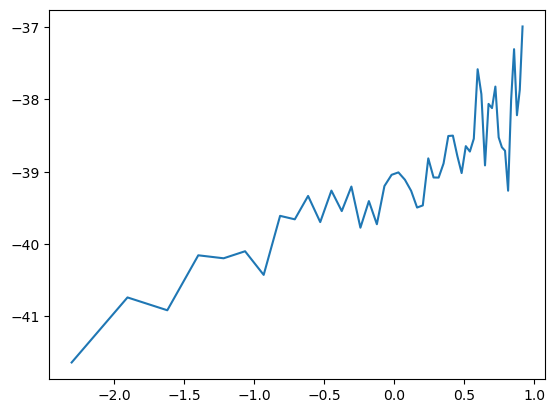

1.0380887466798225


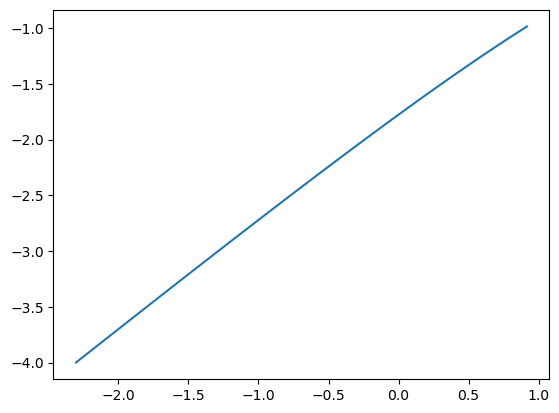

0.9272150992068434


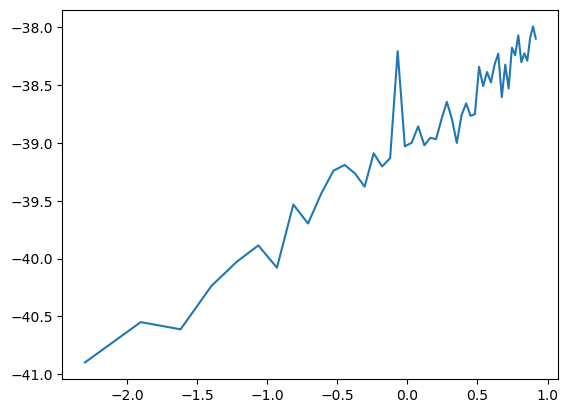

0.8791335212664455


In [288]:
for i in range(8):
    plt.plot(np.log(epsilons),np.log(np.abs(data[i,2,:])))
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(epsilons[:]),np.log(np.abs(data[i,2,:])))
    print(slope)
    
    
    plt.plot(np.log(epsilons),np.log(np.abs(data[i,3,:])))
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(epsilons[:]),np.log(np.abs(data[i,3,:])))
    print(slope)
    
    

    
    


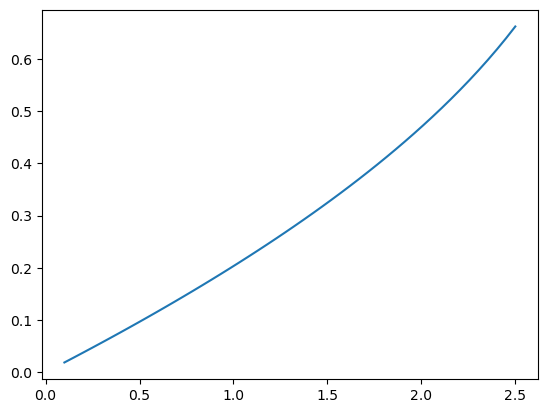

In [275]:
plt.plot(epsilons,data[6,2,:])

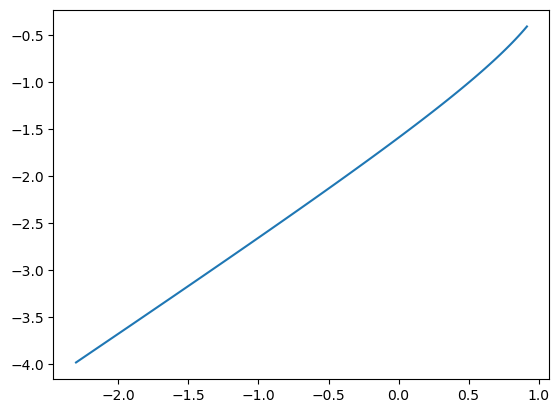

In [276]:
plt.plot(np.log(epsilons[:]),np.log(data[6,2,:]))


In [ ]:
data2 = np.zeros((5,50))
for i in range(50):
    
    epsilon = epsilons[i]



    w = epsilon/T


    print(epsilon)




    closing  = a - np.arange(steps)*epsilon/steps
    opening = a - epsilon + np.arange(steps)*epsilon/steps
    opened = a *np.ones(steps)
    closed = (a-epsilon)*np.ones(steps)
    
    

    
    
  

    
    
    
    

    
    
    

    
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])
    
    
    rf,_ =  act(r0,np.array([closing,opened,opened,opened]),np.array([-w,0,0,0]))

    rf,_ =  act(rf,np.array([closed,closing,opened,opened]),np.array([0,-w,0,0]))

    rf,_ =  act(rf,np.array([closed,closed,closing,opened]),np.array([0,0,-w,0]))
    
    rf,_ =  act(rf,np.array([closed,closed,closed,closing]),np.array([0,0,0,-w]))


    rf,_ =  act(rf,np.array([opening,closed,closed,closed]),np.array([w,0,0,0]))

    rf,_ =  act(rf,np.array([opened,opening,closed,closed]),np.array([0,w,0,0]))

    rf,_ =  act(rf,np.array([opened,opened,opening,closed]),np.array([0,0,w,0]))
    
    rf,change =  act(rf,np.array([opened,opened,opened,opening]),np.array([0,0,0,w]))

    visualize(rf)

    data2[:,i] = change
    
    
    
 


    


#save data

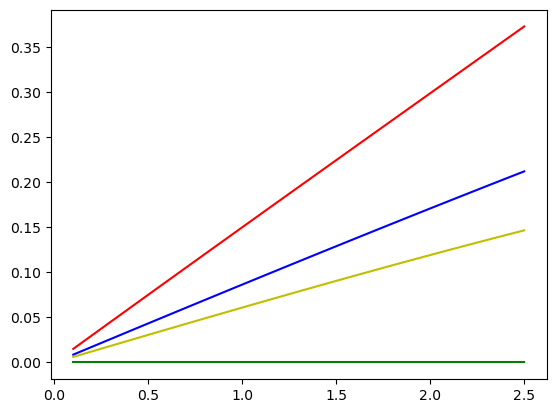

In [301]:
colors = ["b","r","y","w","g"]
for i in range(5):
    plt.plot(epsilons,data2[i],c=colors[i])
    

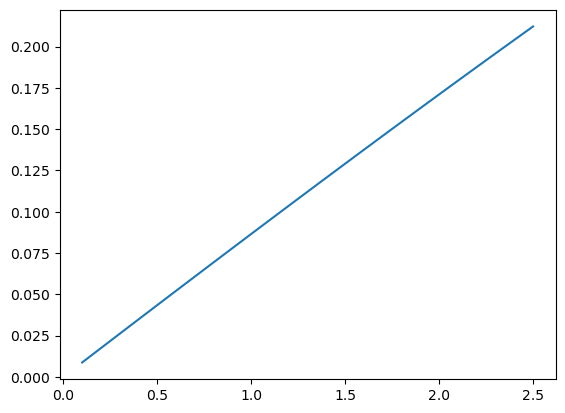

In [295]:
plt.plot(epsilons,data2[])

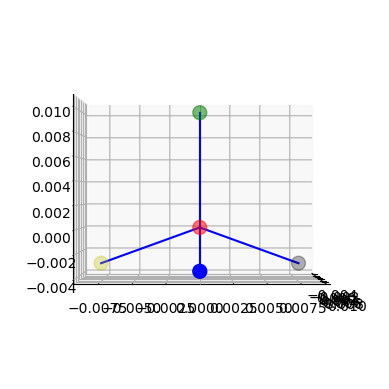

In [17]:
visualize(r0)